# Contextual Banditアルゴリズムで広告配信を最適化してみた

In [2]:
import copy
import math
import random
import time

import numpy as np
import pandas as pd

from pandas import DataFrame
from plotly.offline import iplot, plot

In [3]:
from pymab.model import EpsilonGreedy, LinUCB, HybridLinUCB, LinTS
from mab_tools.test_mab import sim_conmabs_norm, sim_conmabs_bern, mab_plots

## Contextual Multi-Armed Bandit Simulation 1
### 通常のContextual Bandit.

### 設定
- 配信回数5,000回の中でサイト訪問時間かなんか（目的変数が連続量のため）を最大化. <br>
- 各アルゴリズムの推定量は500回の試行につき1回更新.<br>
- LinTSは速度の問題があり, 線形パラメータ推定量$\hat{\theta}$を20回に1回サンプリング.
(-> LinTSの速度のボトルネックは,np.random.multivariate_normalであることを特定済みであるため.このように対処.)
- 50回のシミュレーションの平均値を描画. <br>
- 累積報酬, 累積リグレットで性能比較. <br>

### 比較アルゴリズム
| アルゴリズム | ハイパーパラメータ |
|:-----------|:------------|
|ε-greedy<br>(比較用)|$\epsilon = 0.1$|
|LinTS|$\sigma = 0.01$|
|LinTS |$\sigma = 0.1$ |
|LinUCB|$\alpha = 0.1$ |
|LinUCB|$\alpha = 1.0$ |
|HybridLinUCB|$\alpha=1.0$|

#### 腕の種類（広告1~10）
- 各広告は20次元の真のパラメータ$\theta$を平均0.5, 分散0.3の正規分布から得る.
- 内, 5次元の$\theta$は全広告で同じ値を持つ. (ex. 曜日や天気などの特徴量に対応するパラメータを想定)
- 残りの15次元の$\theta$は広告種類ごとに異なるパラメータの値を持つ. (ex. ユーザーの性別,年齢,居住地,収入などの特徴量に対応するパラメータを想定)

#### 特徴量の作り方
- 特徴量は全て0 or 1の離散値とする. (ダミー変数)
- 試行毎にランダムに30次元のダミー変数をsim_commabs_norm内部でサンプルして, 仮想的なユーザーとしている.

In [4]:
# 全ての広告が同じ係数を持つ特徴量 ex) 日付, 天気 etc.
common = np.matrix([np.random.normal(loc=0.5, scale=0.3, size=5)] * 10)
# 広告ごとに係数が異なる特徴量
unique = np.matrix([np.random.normal(loc=0.5, scale=0.3, size=15) for i in range(10)])

arms = np.concatenate([common, unique], axis=1)
# こんな感じ
arms

matrix([[ 0.409603  ,  0.06155155,  0.49774954,  0.48654308,  0.51385252,
          0.71176989,  0.69383292,  0.88112913,  0.47175742,  0.88719424,
          0.69033087,  1.13205827,  0.66521319,  0.67954067,  0.53403273,
          0.38898987,  0.69988599,  0.62117142, -0.11733252,  0.00271547],
        [ 0.409603  ,  0.06155155,  0.49774954,  0.48654308,  0.51385252,
          1.07646823,  0.97698167,  0.56273741,  0.61955479,  0.62131288,
          0.51401178,  0.73186608,  0.45643441,  0.76451489,  0.47770487,
          0.66291103,  0.48833288,  0.50340771,  0.23172347,  0.1271481 ],
        [ 0.409603  ,  0.06155155,  0.49774954,  0.48654308,  0.51385252,
          0.25381388,  0.58966079,  0.50706159,  0.82785229,  0.20659264,
          0.8886129 ,  0.29585972, -0.23800228,  0.90255242,  0.85872729,
          0.57387941,  0.71820053,  0.84655288,  0.58265651,  0.41866372],
        [ 0.409603  ,  0.06155155,  0.49774954,  0.48654308,  0.51385252,
          0.45309783,  0.49447011, 

In [5]:
# シミュレーション3に用いるアルゴリズムの指定.
algos = [EpsilonGreedy(n_arms=arms.shape[0], batch_size=1, epsilon=0.1),
         LinTS(n_arms=arms.shape[0], feature_dim=arms.shape[1], sigma=0.01, sample_batch_size=20),
         LinTS(n_arms=arms.shape[0], feature_dim=arms.shape[1], sigma=0.1, sample_batch_size=20),
         LinUCB(n_arms=arms.shape[0], feature_dim=arms.shape[1], alpha=10),
         LinUCB(n_arms=arms.shape[0], feature_dim=arms.shape[1], alpha=1),
         HybridLinUCB(n_arms=arms.shape[0], z_dim=common.shape[1], x_dim=unique.shape[1])]

key = [False, True, True, True, True, True]

name_list = ["Epsilon Greedy(ε=0.1)", "LinTS(σ=0.01)", "LinTS(σ=0.1)",
             "LinUCB(α=1)", "LinUCB(α=0.1)", "HybridLinUCB(α=1.0)"]

metrics = ["Cumulative Rewards", "Cumulative Regrets", "Successes"]

## Run Simulations!

In [6]:
result_list = sim_conmabs_norm(algo_list=algos, algo_name=name_list, context_key=key, arms=arms, scale=1.0,
                               num_sims=20, horizon=5000, batch=True, batch_size=500)

Avg Elapsed Time(5000 iter) Epsilon Greedy(ε=0.1) : 0.038s
Avg Elapsed Time(5000 iter) LinTS(σ=0.01) : 0.126s
Avg Elapsed Time(5000 iter) LinTS(σ=0.1) : 0.128s
Avg Elapsed Time(5000 iter) LinUCB(α=1) : 0.13s
Avg Elapsed Time(5000 iter) LinUCB(α=0.1) : 0.131s
Avg Elapsed Time(5000 iter) HybridLinUCB(α=1.0) : 0.438s


## Plot Results!

In [8]:
rewards_plot = mab_plots(df_list=result_list, name_list=name_list, metric=metrics[0])
regret_plot = mab_plots(df_list=result_list, name_list=name_list, metric=metrics[1])
bingo_plot = mab_plots(df_list=result_list, name_list=name_list, metric=metrics[2])

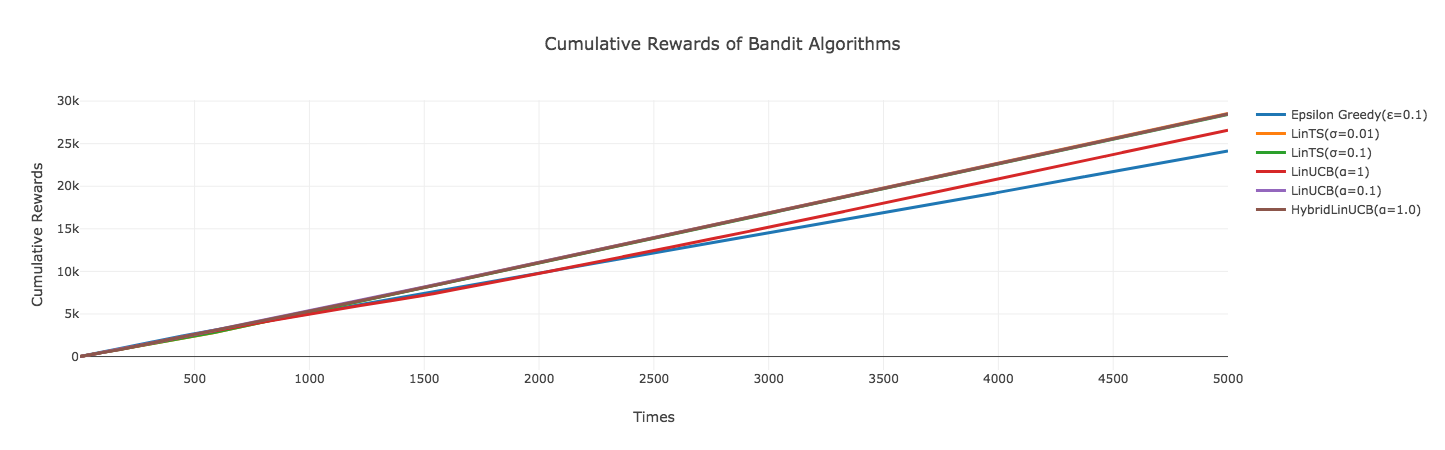

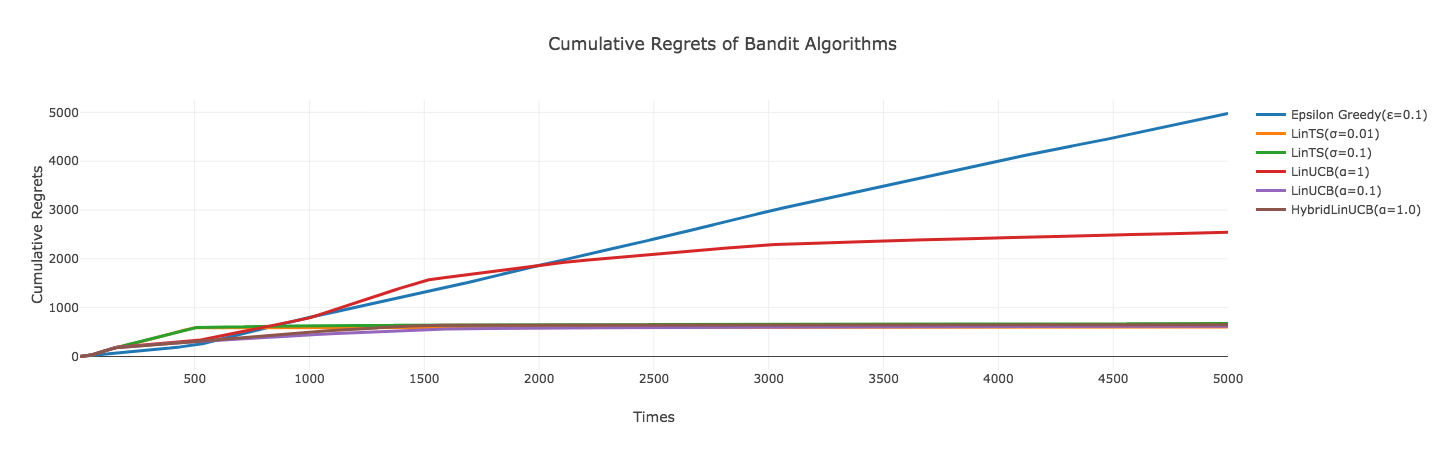

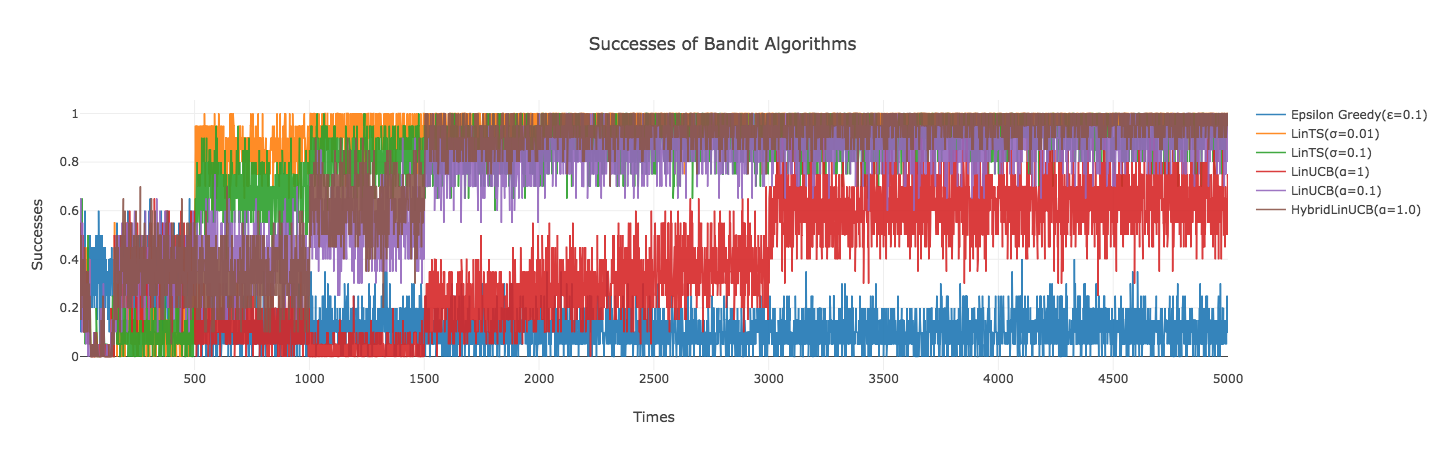

In [9]:
iplot(rewards_plot)
iplot(regret_plot)
iplot(bingo_plot)

## おまけ（本当にパラメータ推定できてる？）

#### 設定
- LinUCBを用いて, 線形モデルのパラメータをバッチリ推定しているのか試す.
- 平均0, 分散3.0の正規分布から8次元の$\theta$をサンプルする.
- アームの数は3種類. つまり, $8 \times 3 = 24$次元のパラメータを当てに行く.
- 10,000回の試行を経た後のLinUCBにおけるパラメータ推定値$\hat{\theta}$を見てみる.

In [12]:
# 推定したいパラメータをサンプル.
arms = np.matrix([np.round(np.random.normal(loc=0, scale=3.0, size=8), 3) for i in range(3)])

# 諸々の変数指定.
rounds = 10000
n_arms = arms.shape[0]
dim = arms.shape[1]

In [13]:
arms

matrix([[-3.54 ,  1.37 , -0.789,  4.34 , -0.311,  1.514, -0.221, -0.519],
        [ 2.624,  0.728,  1.863,  0.08 , -2.563,  1.093, -0.232,  1.629],
        [ 0.68 , -6.482, -4.742, -3.599, -5.161,  0.142, -3.985,  3.226]])

| パラメータ | $\theta_1$ |$\theta_2$ |$\theta_3$ |$\theta_4$ |$\theta_5$ |$\theta_6$ |$\theta_7$ |$\theta_8$ |
|:-----------|:------------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|
| アーム1 |-3.54|1.37| -0.789|  4.34|  -0.311|  1.514|  -0.221| -0.519|
| アーム2 |2.624| 0.728| 1.863| 0.08|  -2.563| 1.093| -0.232| 1.629|
| アーム3 |0.68| -6.482| -4.742|-3.599| -5.161| 0.142|-3.985| 3.226|

## Run a Simulation!

In [14]:
player = LinUCB(n_arms=n_arms, feature_dim=dim)

times = 0
start = time.time()

for t in range(0, rounds):
    x = np.matrix(np.random.randint(2, size=dim)).T

    i = player.select_arm(x) 
    e = np.random.normal(loc=0, scale=1.0)
    reward = arms[i].dot(x) + e
    
    player.update(x, i, reward[0][0])

    times += 1
    if times % (0.25 * rounds) == 0:
        print(f"{100 * times / rounds} % done")
        
print(f"\nElapsed Time : {round(time.time() - start, 3)}s")

25.0 % done
50.0 % done
75.0 % done
100.0 % done

Elapsed Time : 2.353s


In [15]:
np.round(player.theta, 3)

array([[-3.475,  2.598, -0.837],
       [ 1.377,  0.723, -5.117],
       [-0.742,  1.855, -5.064],
       [ 4.269,  0.077, -2.407],
       [-0.311, -2.489, -4.328],
       [ 1.501,  1.101, -0.79 ],
       [-0.234, -0.232, -3.283],
       [-0.507,  1.632,  2.913]])

## Good Estimation!
| パラメータ | $\theta_1$ |$\theta_2$ |$\theta_3$ |$\theta_4$ |$\theta_5$ |$\theta_6$ |$\theta_7$ |$\theta_8$ |
|:-----------|:------------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|
| アーム1<br>(真値) |-3.54|1.37| -0.789|  4.34|  -0.311|  1.514|  -0.221| -0.519|
|アーム1 <br>(推定値)|-3.475  |  1.377| -0.742|  4.269|  -0.311|  1.501|  -0.234|  -0.507|


| パラメータ | $\theta_1$ |$\theta_2$ |$\theta_3$ |$\theta_4$ |$\theta_5$ |$\theta_6$ |$\theta_7$ |$\theta_8$ |
|:-----------|:------------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|
| アーム2 <br>(真値)|2.624| 0.728| 1.863| 0.08|  -2.563| 1.093| -0.232| 1.629|
|アーム2 <br>(推定値)|2.598| 0.723| 1.855| 0.077|  -2.489| 1.101| -0.232| 1.632|

| パラメータ | $\theta_1$ |$\theta_2$ |$\theta_3$ |$\theta_4$ |$\theta_5$ |$\theta_6$ |$\theta_7$ |$\theta_8$ |
|:-----------|:------------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|
| アーム3<br>(真値) |0.68| -6.482| -4.742|-3.599| -5.161| 0.142|-3.985| 3.226|
|アーム3 <br>(推定値)| -0.837|  -5.117|  -5.064| -2.407| -4.328|-0.79| -3.283| 2.913|